In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import yfinance
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import export_graphviz
import vectorbt as vbt
import anywidget
warnings.filterwarnings('ignore')

data = pd.read_csv('data\df.csv',sep='|')
data['date'] = pd.to_datetime(data['date'])

DXY = yfinance.download('DX-Y.NYB', start='1999-01-04', end='2025-09-19')
DXY = DXY.reset_index()[['Date','Close']]
DXY.columns = ['date','DXY']
data=data.merge(DXY, on='date', how='left')

GDPM = pd.read_csv('GDP Monthly.csv',sep=',')
GDPM['date'] = pd.to_datetime(GDPM['timestamp'])
GDPM['year'] = GDPM['date'].dt.year
GDPM['month'] = GDPM['date'].dt.month
GDPM['CroissM'] = GDPM['EIA/GDPQXUS/USA'].diff()

data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

data = data.merge(GDPM, on=['year', 'month'], how='left')
data.drop(['timestamp','date_y','year','month'], axis=1, inplace=True)
data['DXY'].fillna(method='ffill', inplace=True)
print(data.columns)
data.set_index('date_x', inplace=True)

<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
C:\Users\HOME\AppData\Local\Temp\ipykernel_10164\1741883237.py:18: SyntaxWarning: invalid escape sequence '\d'
  data = pd.read_csv('data\df.csv',sep='|')
[*********************100%***********************]  1 of 1 completed

Index(['date_x', 'close', 'volume', 'high', 'low', 'pe',
       'num_daily_adv_minus_decl', 'mov_avg_20d', 'best_eps', 'dvd_sh_last',
       'rsi_3d', 'rsi_9d', 'rsi_14d', 'rsi_30d', 'mov_avg_10d', 'mov_avg_30d',
       'mov_avg_50d', 'pb', 'pib_pct', 'pib', 'vix', 'i', 'i_future',
       'inflation', 'gold', 'gold_pct', 'gold_volume', 'brent', 'brent_pct',
       'brent_volume', 'cible', 'returns', 'vol', 'score', 'momentum_10d',
       'macd', 'macd_signal', 'bb_upper', 'bb_lower', 'mov_avg_100d',
       'mov_avg_200d', 'mov_avg_10_50_diff', 'mov_avg_20_50_diff',
       'close_minus_10d', 'close_minus_20d', 'close_minus_30d',
       'close_minus_50d', 'close_minus_100d', 'close_minus_200d', 'DXY',
       'EIA/GDPQXUS/USA', 'CroissM'],
      dtype='object')


Date 2020-01-02 : entraînement modèle, prédiction et backtesting...
Date 2020-01-03 : entraînement modèle, prédiction et backtesting...
Date 2020-01-06 : entraînement modèle, prédiction et backtesting...
Date 2020-01-07 : entraînement modèle, prédiction et backtesting...
Date 2020-01-08 : entraînement modèle, prédiction et backtesting...
Date 2020-01-09 : entraînement modèle, prédiction et backtesting...
Date 2020-01-10 : entraînement modèle, prédiction et backtesting...
Date 2020-01-13 : entraînement modèle, prédiction et backtesting...
Date 2020-01-14 : entraînement modèle, prédiction et backtesting...
Date 2020-01-15 : entraînement modèle, prédiction et backtesting...
Date 2020-01-16 : entraînement modèle, prédiction et backtesting...
Date 2020-01-17 : entraînement modèle, prédiction et backtesting...
Date 2020-01-21 : entraînement modèle, prédiction et backtesting...
Date 2020-01-22 : entraînement modèle, prédiction et backtesting...
Date 2020-01-23 : entraînement modèle, prédictio

Start                         2020-01-02 00:00:00
End                           2025-09-18 00:00:00
Period                                       1436
Start Value                                 100.0
End Value                              125.328305
Total Return [%]                        25.328305
Benchmark Return [%]                   106.197555
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        29.742845
Max Drawdown Duration                       475.0
Total Trades                                  225
Total Closed Trades                           225
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            63.111111
Best Trade [%]                           5.512575
Worst Trade [%]                          -7.77124
Avg Winning Trade [%]                     1.09173
Avg Losing Trade [%]                    -1.550372


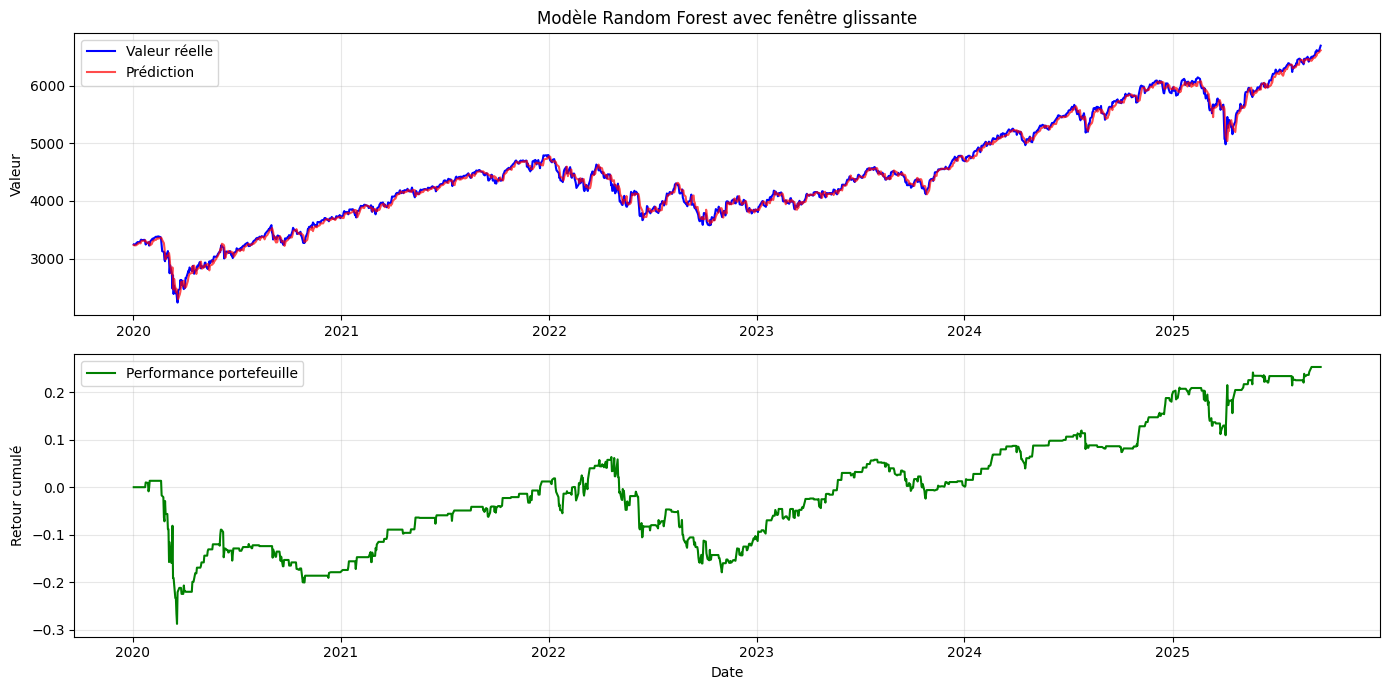

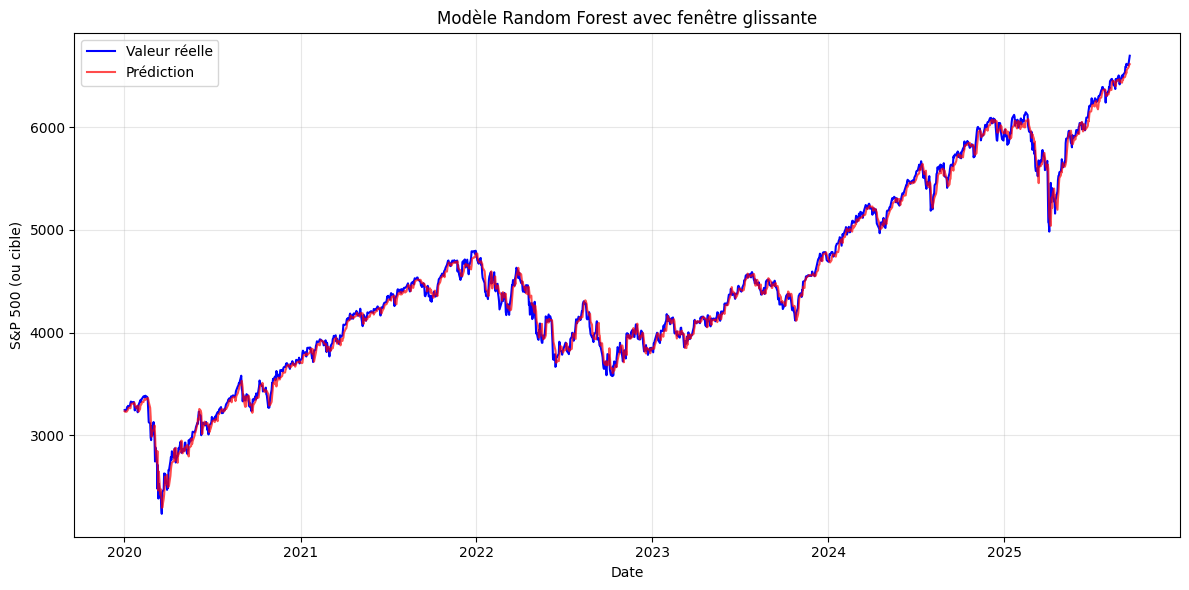

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

window_years = 3  # nombre d'années de données pour entraîner (ex : 3 ans)
trading_days_per_year = 250
window_size = window_years * trading_days_per_year  # ~750 jours
start_date = '2020-01-01'
end_date = '2025-09-18'
df = data.copy()

features = df.drop(columns=['cible'])
target = df['cible']

# === Initialisation des listes === #
predictions = []
true_values = []
prediction_dates = []
signals = []          # signal d'achat (True) ou non (False)
portfolio_returns = []  # rendement journalier du portefeuille

for current_date in pd.date_range(start=start_date, end=end_date, freq='B'):  # freq='B' = jours ouvrés
    if current_date not in df.index:
        continue

    end_train_idx = df.index.get_loc(current_date)
    start_train_idx = end_train_idx - window_size

    if start_train_idx < 0:
        continue  # pas assez d'historique

    # Définir les fenêtres d'entraînement et de test
    X_train = features.iloc[start_train_idx:end_train_idx]
    y_train = target.iloc[start_train_idx:end_train_idx]

    X_test = features.loc[[current_date]]
    y_test = target.loc[current_date]

    # Entraîner le modèle
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    # Prédire
    y_pred = model.predict(X_test)[0]

    # Stocker
    predictions.append(y_pred)
    true_values.append(y_test)
    prediction_dates.append(current_date)

    # Calculer le signal : acheter si la prédiction est plus haute que le dernier prix connu
    last_price = y_train.iloc[-1]
    signal = y_pred > last_price
    signals.append(signal)

    # Calculer le rendement journalier du portefeuille (basé sur le signal précédent)
    if len(signals) > 1:
        prev_signal = signals[-2]
        # Calcul du rendement entre le prix actuel et le précédent
        prev_true = true_values[-2]
        daily_return = (y_test / prev_true) - 1 if prev_signal else 0
        portfolio_returns.append(daily_return)

    print(f"Date {current_date.date()} : entraînement modèle, prédiction et backtesting...")

# Pour aligner les dates des rendements (décalage d’un jour par rapport aux signaux)
returns_dates = prediction_dates[1:]

# === Résultats === #
results = pd.DataFrame({
    'Valeur réelle': true_values,
    'Prédiction': predictions,
    'Signal achat': signals
}, index=prediction_dates)

previous_price = df['cible'].shift(1).reindex(results.index)
entries = results['Prédiction'] > previous_price
exits = ~entries

price = df['cible'].reindex(results.index)

portfolio = vbt.Portfolio.from_signals(
    close=price,
    entries=entries,
    exits=exits
)

portfolio.plot().show()
print(portfolio.stats())

# === Évaluation === #
mae = mean_absolute_error(results['Valeur réelle'], results['Prédiction'])
print(f"\n✅ MAE global ({start_date} ➜ {end_date}): {mae:.2f}\n")

print(results.head())

# === Performance portefeuille === #
portfolio_returns = np.array(portfolio_returns)
cumulative_returns = np.cumprod(1 + portfolio_returns) - 1

print(f"Retour cumulé du portefeuille: {cumulative_returns[-1]:.2%}")

# === Affichage === #
plt.figure(figsize=(14,7))

plt.subplot(2,1,1)
plt.plot(results.index, results['Valeur réelle'], label='Valeur réelle', color='blue')
plt.plot(results.index, results['Prédiction'], label='Prédiction', color='red', alpha=0.7)
plt.title("Modèle Random Forest avec fenêtre glissante")
plt.ylabel("Valeur")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2,1,2)
plt.plot(returns_dates, cumulative_returns, label='Performance portefeuille', color='green')
plt.xlabel("Date")
plt.ylabel("Retour cumulé")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === Affichage === #
plt.figure(figsize=(12,6))
plt.plot(results.index, results['Valeur réelle'], label='Valeur réelle', color='blue')
plt.plot(results.index, results['Prédiction'], label='Prédiction', color='red', alpha=0.7)
plt.title("Modèle Random Forest avec fenêtre glissante")
plt.xlabel("Date")
plt.ylabel("S&P 500 (ou cible)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

